In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## define psf

In [2]:
from __future__ import annotations

import numpy as np
from numpy.typing import ArrayLike
from typing import Literal, Optional


# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------

def _ensure_1d(x: ArrayLike) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.ndim == 0:
        x = x[None]
    if x.ndim != 1:
        raise ValueError("Input must be 1D (or scalar).")
    return x


def _trapz_weights_1d(x: np.ndarray) -> np.ndarray:
    """
    Trapezoidal quadrature weights w such that sum_j f(x_j) w_j ≈ ∫ f(x) dx.
    """
    x = _ensure_1d(x)
    n = x.size
    if n == 1:
        return np.array([1.0], dtype=float)

    dx = np.diff(x)
    if np.any(dx <= 0):
        raise ValueError("Grid must be strictly increasing.")

    w = np.empty(n, dtype=float)
    w[0] = 0.5 * dx[0]
    w[-1] = 0.5 * dx[-1]
    w[1:-1] = 0.5 * (dx[:-1] + dx[1:])
    return w


def renormalize_rows(R: np.ndarray, q_grid: np.ndarray) -> np.ndarray:
    """
    Enforce (numerically) ∫ R(Q_i, q) dq = 1 for each row i, using trapz weights.
    """
    q = _ensure_1d(q_grid)
    w = _trapz_weights_1d(q)  # (M_mod,)
    row_mass = R @ w          # (M_obs,)
    # Avoid division by zero for rows with zero support
    scale = np.where(row_mass > 0, 1.0 / row_mass, 1.0)
    return R * scale[:, None]


def _gaussian_smoother(grid: np.ndarray, mu: float) -> Optional[np.ndarray]:
    """
    Column-stochastic Gaussian smoother S so that y_sm ≈ S @ y.
    If mu <= 0, returns None.
    """
    if mu is None or mu <= 0:
        return None
    x = _ensure_1d(grid)
    dx_min = np.min(np.diff(x)) if x.size > 1 else 1.0
    mu_eff = max(mu, 0.5 * dx_min)

    X = x[:, None]
    Y = x[None, :]
    K = np.exp(-0.5 * ((X - Y) / mu_eff) ** 2)
    K /= np.maximum(K.sum(axis=1, keepdims=True), 1e-300)
    return K


def _slit_params(Q: np.ndarray, epsilon: float, phi: Literal[0, "0", "parallel", "pi/2", "perp", 1]) -> tuple[np.ndarray, float, float]:
    """
    Returns:
      Qeff(Q): effective lower-bound location of the integrable singularity.
      qmax(Q): upper support bound.
      pref:  overall prefactor multiplying q/sqrt(q^2 - Qeff^2).
    """
    Q = _ensure_1d(Q)
    if 1.0 + epsilon <= 0:
        raise ValueError("Require 1+epsilon > 0.")

    if phi in (0, "0", "parallel"):
        # Case I: phi = 0 (strain axis parallel to slit)
        # R = ((1+eps)/sigma_y) * q / sqrt(q^2 - Q^2)
        # support: Q <= q <= sqrt(Q^2 + (sigma_y/(1+eps))^2)
        Qeff = Q
        pref = (1.0 + epsilon)  # /sigma_y handled later
        # qmax depends on sigma_y too -> computed outside with sigma_y
        # We'll return factor to build qmax: sqrt(Q^2 + (sigma_y/(1+eps))^2)
        return Qeff, pref, 0.0  # placeholder for case flag
    elif phi in ("pi/2", "perp", 1):
        # Case II: phi = pi/2 (strain axis perpendicular to slit)
        # R = (1/sigma_y) * q / sqrt(q^2 - (Q/(1+eps))^2)
        # support: Q/(1+eps) <= q <= sqrt((Q/(1+eps))^2 + sigma_y^2)
        Qeff = Q / (1.0 + epsilon)
        pref = 1.0  # /sigma_y handled later
        return Qeff, pref, 1.0  # placeholder for case flag
    else:
        raise ValueError("phi must be one of: 0, 'parallel', 'pi/2', 'perp'.")


# -----------------------------------------------------------------------------
# 1) Definition-based anisotropic slit PSF (phi = 0 or pi/2 only)
# -----------------------------------------------------------------------------

def R_slit_aniso(
    Q_obs: ArrayLike,
    q_mod: ArrayLike,
    sigma_y: float,
    epsilon: float,
    *,
    phi: Literal[0, "0", "parallel", "pi/2", "perp", 1] = 0,
    mu_q: float = 0.0,
    eps_reg: float = 1e-15,
    renormalize: bool = True,
) -> np.ndarray:
    r"""
    Orientation-resolved *anisotropic* slit PSF for the two special cases:

    Case I (phi = 0, "parallel"):
        R_slit(Q,q) = (1+epsilon)/sigma_y * q / sqrt(q^2 - Q^2),
        support: Q <= q <= sqrt(Q^2 + (sigma_y/(1+epsilon))^2).

    Case II (phi = pi/2, "perp"):
        R_slit(Q,q) = 1/sigma_y * q / sqrt(q^2 - (Q/(1+epsilon))^2),
        support: Q/(1+epsilon) <= q <= sqrt((Q/(1+epsilon))^2 + sigma_y^2).

    Parameters
    ----------
    Q_obs : (M_obs,) array
        Observed horizontal momentum transfers Q (assumed nonnegative).
    q_mod : (M_mod,) array
        Model grid q where latent intensity I(q) is defined.
    sigma_y : float
        Half slit width in Q_y units.
    epsilon : float
        Affine strain parameter (requires 1+epsilon > 0).
    phi : {0, "parallel", "pi/2", "perp"}
        Only these two orientations are supported.
    mu_q : float
        Optional Gaussian smoothing along q_mod (right-multiply by S^T).
    eps_reg : float
        Small regularization added under sqrt to avoid division by zero at the
        integrable singularity when sampled exactly on-grid.
    renormalize : bool
        If True, normalize each row so ∫ R(Q_i,q) dq ≈ 1.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp(Q) ≈ (R @ I_mod)(Q).
    """
    Q = _ensure_1d(Q_obs)
    q = _ensure_1d(q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive.")
    if np.any(q <= 0):
        # not strictly required, but typical for scattering q-grid
        pass

    Qeff, pref, case_flag = _slit_params(Q, epsilon, phi)

    # Build qmax for each Q
    if case_flag == 0.0:
        # phi = 0: qmax = sqrt(Q^2 + (sigma_y/(1+eps))^2)
        qmax = np.sqrt(Q**2 + (sigma_y / (1.0 + epsilon)) ** 2)
    else:
        # phi = pi/2: qmax = sqrt((Q/(1+eps))^2 + sigma_y^2)
        qmax = np.sqrt(Qeff**2 + sigma_y**2)

    # Broadcast to (M_obs, M_mod)
    Qeff_mat = Qeff[:, None]
    qmax_mat = qmax[:, None]
    q_row = q[None, :]

    support = (q_row >= Qeff_mat) & (q_row <= qmax_mat)

    denom_sq = q_row**2 - Qeff_mat**2
    denom = np.sqrt(np.maximum(denom_sq, 0.0) + eps_reg**2)

    with np.errstate(divide="ignore", invalid="ignore"):
        base = (pref / sigma_y) * (q_row / denom)
        R = np.where(support, base, 0.0)

    # Optional smoothing along q (right-multiply by S^T)
    S = _gaussian_smoother(q, mu_q)
    if S is not None:
        R = R @ S.T

    if renormalize:
        R = renormalize_rows(R, q)

    return R


# -----------------------------------------------------------------------------
# 2) Thin-rectangle (bin-averaged) approximation to remove sampled singularity
# -----------------------------------------------------------------------------

def R_slit_aniso_rect(
    Q_obs: ArrayLike,
    q_mod: ArrayLike,
    sigma_y: float,
    epsilon: float,
    *,
    phi: Literal[0, "0", "parallel", "pi/2", "perp", 1] = 0,
    mu_q: float = 0.0,
    thin_dq: Optional[float] = None,
    renormalize: bool = True,
) -> np.ndarray:
    r"""
    "Very thin rectangular slit" approximation in q to avoid the pointwise
    integrable singularity at q = Q_eff by *cell-averaging* each q-bin.

    Uses the analytic identity:
        ∫ q / sqrt(q^2 - a^2) dq = sqrt(q^2 - a^2).

    For each observed Q_i and each bin [L_k, U_k] (a thin rectangle in q),
    we compute:
        (1/Δq_k) ∫_{intersection} pref/sigma_y * q/sqrt(q^2-a^2) dq
      = pref/sigma_y * ( sqrt(U^2-a^2) - sqrt(L^2-a^2) ) / Δq_k,
    where a = Q_eff(Q_i) and the intersection is further limited to the support
    [Q_eff, qmax].

    Parameters
    ----------
    Q_obs, q_mod, sigma_y, epsilon, phi, mu_q, renormalize :
        Same meaning as in `R_slit_aniso`.
    thin_dq : float or None
        If None: use bin edges inferred from q_mod (midpoints).
        If provided: use a uniform "thin rectangle" width thin_dq centered at
        each q_mod[k], i.e. [q_k - thin_dq/2, q_k + thin_dq/2].

    Returns
    -------
    R : (M_obs, M_mod) array
        Bin-averaged kernel such that I_exp(Q) ≈ (R @ I_mod)(Q).
    """
    Q = _ensure_1d(Q_obs)
    q = _ensure_1d(q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive.")
    if q.size < 2 and thin_dq is None:
        raise ValueError("q_mod must have at least 2 points if thin_dq is None.")
    if thin_dq is not None and thin_dq <= 0:
        raise ValueError("thin_dq must be positive if provided.")

    Qeff, pref, case_flag = _slit_params(Q, epsilon, phi)

    # qmax for each Q
    if case_flag == 0.0:
        qmax = np.sqrt(Q**2 + (sigma_y / (1.0 + epsilon)) ** 2)
    else:
        qmax = np.sqrt(Qeff**2 + sigma_y**2)

    M_obs, M_mod = Q.size, q.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # Build "thin rectangle" bins in q
    if thin_dq is None:
        edges = np.empty(M_mod + 1, dtype=float)
        edges[1:-1] = 0.5 * (q[1:] + q[:-1])
        edges[0] = q[0] - 0.5 * (q[1] - q[0])
        edges[-1] = q[-1] + 0.5 * (q[-1] - q[-2])
        L0 = edges[:-1]  # (M_mod,)
        U0 = edges[1:]   # (M_mod,)
        dQ = U0 - L0
    else:
        half = 0.5 * thin_dq
        L0 = q - half
        U0 = q + half
        dQ = np.full_like(q, thin_dq, dtype=float)

    # Row-by-row (broadcast-friendly over bins)
    for i in range(M_obs):
        a = Qeff[i]
        b = qmax[i]

        # Intersect each bin with the admissible support [a, b]
        L = np.maximum(L0, a)
        U = np.minimum(U0, b)
        valid = U > L

        if not np.any(valid):
            continue

        # Compute sqrt(U^2-a^2) - sqrt(L^2-a^2)
        # Note: L,U >= a by construction in the valid set.
        termU = np.sqrt(np.maximum(U[valid] ** 2 - a * a, 0.0))
        termL = np.sqrt(np.maximum(L[valid] ** 2 - a * a, 0.0))

        r_line = np.zeros(M_mod, dtype=float)
        r_line[valid] = (pref / sigma_y) * (termU - termL) / dQ[valid]
        R[i, :] = r_line

    # Optional smoothing along q
    S = _gaussian_smoother(q, mu_q)
    if S is not None:
        R = R @ S.T

    if renormalize:
        R = renormalize_rows(R, q)

    return R



## isotropic psf

In [3]:
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R


In [4]:
import numpy as np
from numpy.typing import ArrayLike
from typing import Literal, Optional


def f_I_phi(
    Q: ArrayLike,
    I_iso: ArrayLike,
    *,
    epsilon: float,
    phi: Literal[0, "0", "parallel", "pi/2", "perp"] = 0,
    mu_q: float = 0.0,
    kind: Optional[str] = "linear",
    powerlaw_nfit: int = 8,
    powerlaw_floor: float = 1e-300,
) -> np.ndarray:
    r"""
    Directional *true* spectrum I_phi(Q) from isotropic I_iso(q) under affine strain,
    for phi = 0 and phi = pi/2, with optional *power-law extrapolation* at both ends.

    Mapping:
      - phi = 0      : q = Q                 => I_phi(Q) = I_iso(Q)
      - phi = pi/2   : q = Q/(1+epsilon)     => I_phi(Q) = I_iso(Q/(1+epsilon))

    Extrapolation:
      If `kind is not None`, extrapolate outside the tabulated Q-range using power laws
      fitted on log-log to the first/last `powerlaw_nfit` points.

    Parameters
    ----------
    Q : (N,) array
        Grid where I_iso is sampled (also used as the q-grid for I_iso(q)).
    I_iso : (N,) array
        Isotropic spectrum sampled on Q-grid.
    epsilon : float
        Affine strain parameter, requires 1+epsilon > 0.
    phi : {0, "parallel", "pi/2", "perp"}
        Special orientations supported.
    mu_q : float
        Optional Gaussian smoothing applied after resampling (in Q-space).
    kind : str or None
        If None: out-of-range values are set to 0.
        If not None: inside-range uses np.interp (linear), outside-range uses power-law extrap.
    powerlaw_nfit : int
        Number of points to fit each end power law (clipped to [2, N]).
    powerlaw_floor : float
        Floor to avoid log(0) during power-law fitting.

    Returns
    -------
    I_phi : (N,) array
        Directional (true) spectrum on the input Q grid.
    """
    Q = np.asarray(Q, dtype=float)
    I_iso = np.asarray(I_iso, dtype=float)
    if Q.ndim != 1 or I_iso.ndim != 1 or Q.size != I_iso.size:
        raise ValueError("Q and I_iso must be 1D arrays of the same length.")
    if Q.size < 2:
        raise ValueError("Q must have at least 2 points.")
    if np.any(np.diff(Q) <= 0):
        raise ValueError("Q must be strictly increasing.")
    if 1.0 + epsilon <= 0:
        raise ValueError("Require 1 + epsilon > 0.")

    # --- affine mapping q(Q; phi) ---
    if phi in (0, "0", "parallel"):
        q_eval = Q.copy()
    elif phi in ("pi/2", "perp"):
        q_eval = Q / (1.0 + epsilon)
    else:
        raise ValueError("phi must be one of: 0, 'parallel', 'pi/2', 'perp'.")

    Qmin, Qmax = Q[0], Q[-1]

    # --- interpolation + (optional) power-law extrapolation ---
    if kind is None:
        I_phi = np.interp(q_eval, Q, I_iso, left=0.0, right=0.0)
    else:
        # Inside-range interpolation
        I_phi = np.interp(q_eval, Q, I_iso)  # no left/right fill yet

        # Fit power laws on both ends in log-log: log I = a + b log Q  => I = exp(a) Q^b
        nfit = int(np.clip(powerlaw_nfit, 2, Q.size))

        def _fit_powerlaw(Q_fit: np.ndarray, I_fit: np.ndarray) -> tuple[float, float]:
            # returns (a, b) for log I = a + b log Q
            I_pos = np.maximum(I_fit, powerlaw_floor)
            x = np.log(Q_fit)
            y = np.log(I_pos)
            b, a = np.polyfit(x, y, deg=1)
            return float(a), float(b)

        aL, bL = _fit_powerlaw(Q[:nfit], I_iso[:nfit])
        aR, bR = _fit_powerlaw(Q[-nfit:], I_iso[-nfit:])

        left_mask = q_eval < Qmin
        right_mask = q_eval > Qmax

        if np.any(left_mask):
            qL = np.maximum(q_eval[left_mask], powerlaw_floor)
            I_phi[left_mask] = np.exp(aL) * (qL ** bL)

        if np.any(right_mask):
            qR = np.maximum(q_eval[right_mask], powerlaw_floor)
            I_phi[right_mask] = np.exp(aR) * (qR ** bR)

    # --- optional Gaussian smoothing in Q-space ---
    if mu_q and mu_q > 0:
        dQ_min = np.min(np.diff(Q))
        mu_eff = max(float(mu_q), 0.5 * float(dQ_min))
        X = Q[:, None]
        Y = Q[None, :]
        G = np.exp(-0.5 * ((X - Y) / mu_eff) ** 2)
        G /= np.maximum(G.sum(axis=1, keepdims=True), 1e-300)
        I_phi = G @ I_phi

    return I_phi

def f_I_phi_std(Q, I_iso, delta_I_iso, epsilon, phi, mu_q=0.0, kind="linear"):
    """
    Compute the directional spectrum I_phi(Q) and its propagated uncertainty delta_I_phi(Q)
    from isotropic I_iso(q) and delta_I_iso(q) under affine strain.

    Parameters
    ----------
    Q : array
        Grid where I_iso is sampled (also used as the q-grid for I_iso(q)).
    I_iso : array
        Isotropic spectrum sampled on Q-grid.
    delta_I_iso : array
        Uncertainty in the isotropic spectrum sampled on Q-grid.
    epsilon : float
        Affine strain parameter, requires 1+epsilon > 0.
    phi : {0, "parallel", "pi/2", "perp"}
        Special orientations supported.
    mu_q : float
        Optional Gaussian smoothing applied after resampling (in Q-space).
    kind : str
        Interpolation method for out-of-range values.

    Returns
    -------
    I_phi : array
        Directional spectrum on the input Q grid.
    delta_I_phi : array
        Propagated uncertainty in the directional spectrum on the input Q grid.
    """
    # Compute I_phi
    I_phi = f_I_phi(Q, I_iso, epsilon=epsilon, phi=phi, mu_q=mu_q, kind=kind)

    # Propagate uncertainty using the same mapping
    delta_I_phi = f_I_phi(Q, delta_I_iso, epsilon=epsilon, phi=phi, mu_q=mu_q, kind=kind)

    return I_phi, delta_I_phi


## test psf

In [5]:
from scipy.special import sici as sici
def S_rod(q,L):
    y = 2*sici(q*L)[0]/(q*L) - 4*np.sin(q*L/2)**2/(q*L)**2

    return y  
def S_gauss(q,Rg):
    u = (q*Rg)**2
    y = 2*(np.exp(-u) + u - 1)/u**2

    return y

In [6]:
Q_min = 5e-5
Q_max = 0.2
# Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_sampled = np.logspace(np.log10(Q_min), np.log10(Q_max), 200)  # experimental Q

I_iso = S_gauss(Q_sampled,1000)
epsilon = 0.2
sigma_y = 0.1

# ---------------------------------------------------------------------
# Build anisotropic slit PSF and smear I_iso (following *exactly* your pattern)
# ---------------------------------------------------------------------

# Choose orientation: phi = 0 (parallel) or phi = "pi/2" (perpendicular)
phi = 0  # or "pi/2"

# --- Forward smearing operator: R_raw (UN-normalized) ---

I_smeared_list = []
I_phi_parallel_list = []
I_phi_perp_list = []
epsilon_list = [0.0, 0.2, 0.5, 1.0]
for epsilon in epsilon_list:
    R_raw = R_slit_aniso_rect(
        Q_obs=Q_sampled,
        q_mod=Q_sampled,      # latent grid = same as sampled grid here
        sigma_y=sigma_y,
        epsilon=epsilon,
        phi=phi,
        mu_q=0.0,
    )                         # shape (N_obs, N_lat)

    def f_smear(R_raw, I_lat, Q_lat):
        w = np.zeros_like(Q_lat)
        w[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
        w[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
        w[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])
        num = R_raw * w[None, :]
        row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
        R_mat = num / row_sum
        return R_mat @ I_lat, R_mat

    I_smeared, R = f_smear(R_raw, I_iso, Q_sampled)
    I_smeared_list.append(I_smeared)
    
    I_phi_parallel = f_I_phi(
        Q=Q_sampled,
        I_iso=I_iso,
        epsilon=epsilon,
        phi="0",
        mu_q=0.0,
        kind="linear",
    )
    I_phi_parallel_list.append(I_phi_parallel)
    I_phi_perp = f_I_phi(
        Q=Q_sampled,
        I_iso=I_iso,
        epsilon=epsilon,
        phi="pi/2",
        mu_q=0.0,
        kind="linear",
    )
    I_phi_perp_list.append(I_phi_perp)
    
# Use rectangular (bin-averaged) version to avoid singularity
R_raw = R_slit_aniso_rect(
    Q_obs=Q_sampled,
    q_mod=Q_sampled,      # latent grid = same as sampled grid here
    sigma_y=sigma_y,
    epsilon=epsilon,
    phi=phi,
    mu_q=0.0,
)                         # shape (N_obs, N_lat)

def f_smear(R_raw, I_lat, Q_lat):
    w = np.zeros_like(Q_lat)
    w[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
    w[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
    w[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])
    num = R_raw * w[None, :]
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    R_mat = num / row_sum
    return R_mat @ I_lat, R_mat

I_smeared, R = f_smear(R_raw, I_iso, Q_sampled)

R_raw_iso = R_rect(
    Qx_obs=Q_sampled,
    Q_mod=Q_sampled,
    sigma_x=sigma_y*1e-7,
    sigma_y=sigma_y,
    nx=64,
    mu_Q=0.0,
    cell_average=True,
)

I_smeared_iso, R_iso = f_smear(R_raw_iso, I_iso, Q_sampled)

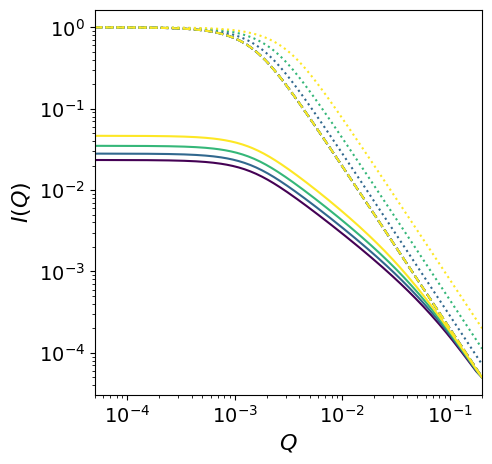

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

# ax.plot(Q_sampled, I_iso, label=r'$I_\mathrm{iso}(q)$', color='blue')

for iepsilon, I_smeared in enumerate(I_smeared_list):
    color = plt.cm.viridis(iepsilon / (len(epsilon_list)-1))
    ax.plot(Q_sampled, I_smeared, label=rf'$\epsilon={epsilon_list[iepsilon]}$', linestyle='-', color=color)
    ax.plot(Q_sampled, I_phi_parallel_list[iepsilon], label=r'$I_{\parallel}(Q)$', color=color, linestyle='--')
    ax.plot(Q_sampled, I_phi_perp_list[iepsilon], label=r'$I_{\perp}(Q)$', color=color, linestyle=':')
# ax.plot(Q_sampled, I_smeared_iso, label=r'Isotropic Smeared $I(q)$', color='r', linestyle='--')

ax.set_xlim(Q_min, Q_max)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$Q$", fontsize=16)
ax.set_ylabel(r"$I(Q)$", fontsize=16)
# ax.legend(fontsize=10, frameon=False)
ax.tick_params(axis='both', which='major', labelsize=14)

## schematic plot

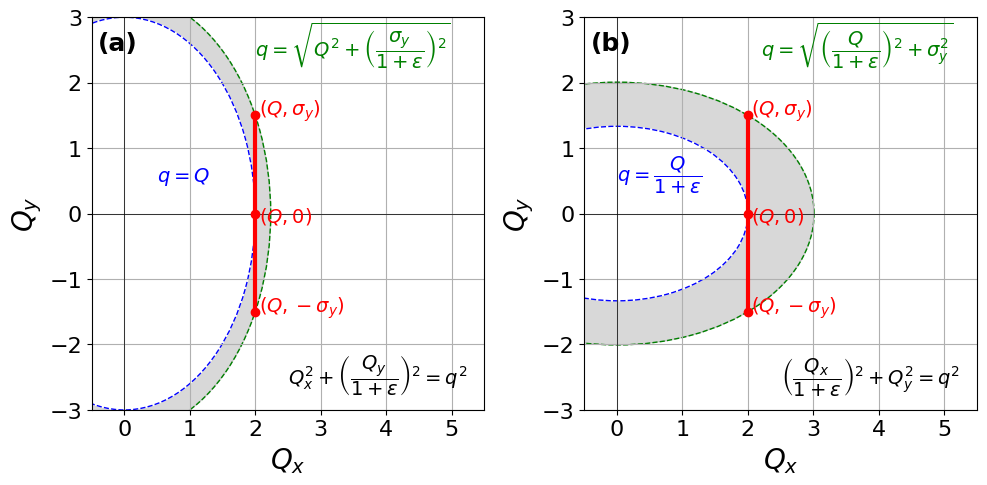

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_grayscale_bg(ax, q_of_QxQy, I_iso_func, xlim, ylim, nx=500, ny=500):
    """
    Adds a grayscale background by evaluating I_iso(q(Qx,Qy)) on a grid.
    - q_of_QxQy: callable (Qx, Qy) -> q
    - I_iso_func: callable q -> I(q)
    """
    Qx = np.linspace(xlim[0], xlim[1], nx)
    Qy = np.linspace(ylim[0], ylim[1], ny)
    X, Y = np.meshgrid(Qx, Qy)

    q = q_of_QxQy(X, Y)
    I = I_iso_func(q)

    # Robust normalization for display (avoid one bright pixel dominating)
    I = np.asarray(I, dtype=float)
    I[I < 0] = 0.0
    lo, hi = np.percentile(I, [1, 99.5])
    if hi <= lo:
        lo, hi = I.min(), I.max() + 1e-12
    In = (I - lo) / (hi - lo)
    In = np.clip(In, 0, 1)

    ax.imshow(
        In,
        origin="lower",
        extent=(xlim[0], xlim[1], ylim[0], ylim[1]),
        cmap="gray",
        interpolation="bilinear",
        alpha=1.0,
        zorder=0,
    )
    
panel_labels = ['(a)', '(b)']

# ---------- Common parameters ----------
Qx_val = 2.0
sigma_y_val = 1.5
epsilon = 0.5
s = 1.0 + epsilon
Qy_sample = 1.0

# ---------- Helper to draw ellipse arcs ----------
def draw_ellipse_arc(ax, a_x, a_y, theta_max, color, ls, lw=1):
    arc = patches.Arc(
        (0, 0),
        2 * a_x,
        2 * a_y,
        theta1=0,
        theta2=theta_max,
        color=color,
        ls=ls,
        lw=lw,
    )
    ax.add_patch(arc)

# ==================== Parallel case ====================
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1)

ax.axhline(0, color="black", lw=0.5)
ax.axvline(0, color="black", lw=0.5)

# Slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], "r-", lw=3)

# Slit points
ax.plot([Qx_val], [0], "ro")
ax.plot([Qx_val], [sigma_y_val], "ro")
ax.plot([Qx_val], [-sigma_y_val], "ro")

ax.text(Qx_val + 0.05, -0.12, r"$(Q,0)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, sigma_y_val, r"$(Q,\sigma_y)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, -sigma_y_val, r"$(Q,-\sigma_y)$", fontsize=14, color="r")

# Blue ellipse: q^2 = Q_x^2 + (Q_y/(1+epsilon))^2 = Q^2
q_min_par = Qx_val
draw_ellipse_arc(ax, q_min_par, s * q_min_par, 360, "blue", "--")
ax.text(0.5, 0.5, r"$q = Q$",
    color="blue", fontsize=14)

# Green ellipse: q^2 = Q_x^2 + (Q_y/(1+epsilon))^2 = Q^2 + (\sigma_y/(1+\epsilon))^2
q_max_par = np.sqrt(Qx_val**2 + (sigma_y_val / s) ** 2)
draw_ellipse_arc(ax, q_max_par, s * q_max_par, 360, "green", "--")
ax.text(2, 2.4,
    r"$q = \sqrt{Q^2 + \left(\dfrac{\sigma_y}{1+\epsilon}\right)^2}$",
    color="green", fontsize=14)

# Background: Add a patch to represent the area between the green and blue ellipses
ellipse_outer = patches.Ellipse(
    (0, 0), 2 * q_max_par, 2 * s * q_max_par, color="gray", alpha=0.3, zorder=0
)
ellipse_inner = patches.Ellipse(
    (0, 0), 2 * q_min_par, 2 * s * q_min_par, color="white", alpha=1.0, zorder=0
)
ax.add_patch(ellipse_outer)
ax.add_patch(ellipse_inner)

# # Sample point
# ax.plot([Qx_val], [Qy_sample], "ko")
# ax.text(Qx_val + 0.05, Qy_sample, r"$(Q,Q_y)$", fontsize=14)
ax.text(2.5,-2.6, r"$Q_x^2 + \left(\dfrac{Q_y}{1+\epsilon}\right)^2 = q^2$", fontsize=14)

# panel label
ax.text(-0.4, 2.5, panel_labels[0], fontsize=18, weight='bold')

# Formatting
ax.set_xlabel(r"$Q_x$", fontsize=20)
ax.set_ylabel(r"$Q_y$", fontsize=20)
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-3, 3)
ax.set_xticks(np.arange(0, 6, 1))
ax.set_aspect("equal", adjustable="box")
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(True)

# ==================== Perpendicular case ====================
ax = fig.add_subplot(1, 2, 2)

ax.axhline(0, color="black", lw=0.5)
ax.axvline(0, color="black", lw=0.5)

# Slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], "r-", lw=3)

# Slit points
ax.plot([Qx_val], [0], "ro")
ax.plot([Qx_val], [sigma_y_val], "ro")
ax.plot([Qx_val], [-sigma_y_val], "ro")

ax.text(Qx_val + 0.05, -0.12, r"$(Q,0)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, sigma_y_val, r"$(Q,\sigma_y)$", fontsize=14, color="r")
ax.text(Qx_val + 0.05, -sigma_y_val, r"$(Q,-\sigma_y)$", fontsize=14, color="r")

# Blue ellipse: q^2 = (Q_x/(1+epsilon))^2 + Q_y^2 = (Q/(1+epsilon))^2
q_min_perp = Qx_val / s
draw_ellipse_arc(ax, s * q_min_perp, q_min_perp, 360, "blue", "--")
ax.text(0, 0.5,
    r"$q = \dfrac{Q}{1+\epsilon}$",
    color="blue", fontsize=14)

# Green ellipse: q^2 = (Q_x/(1+epsilon))^2 + Q_y^2 = (Q/(1+epsilon))^2 + \sigma_y^2
q_max_perp = np.sqrt((Qx_val / s) ** 2 + sigma_y_val**2)
draw_ellipse_arc(ax, s * q_max_perp, q_max_perp, 360, "green", "--")
ax.text(2.2, 2.4,
    r"$q = \sqrt{\left(\dfrac{Q}{1+\epsilon}\right)^2 + \sigma_y^2}$",
    color="green", fontsize=14)

# Background: Add a patch to represent the area between the green and blue ellipses
ellipse_outer = patches.Ellipse(
    (0, 0), 2 * s * q_max_perp, 2 * q_max_perp, color="gray", alpha=0.3, zorder=0
)
ellipse_inner = patches.Ellipse(
    (0, 0), 2 * s * q_min_perp, 2 * q_min_perp, color="white", alpha=1.0, zorder=0
)
ax.add_patch(ellipse_outer)
ax.add_patch(ellipse_inner)

# # Sample point
# ax.plot([Qx_val], [Qy_sample], "ko")
# ax.text(Qx_val + 0.05, Qy_sample, r"$(Q,Q_y)$", fontsize=14)
ax.text(2.5,-2.6, r"$\left(\dfrac{Q_x}{1+\epsilon}\right)^2 + Q_y^2 = q^2$", fontsize=14)

# panel label
ax.text(-0.4, 2.5, panel_labels[1], fontsize=18, weight='bold')

# Formatting
ax.set_xlabel(r"$Q_x$", fontsize=20)
ax.set_ylabel(r"$Q_y$", fontsize=20)
ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-3, 3)
ax.set_xticks(np.arange(0, 6, 1))
ax.set_aspect("equal", adjustable="box")
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(True)

# # Background: q^2 = (Qx/(1+epsilon))^2 + Qy^2
# add_grayscale_bg(
#     ax,
#     q_of_QxQy=lambda Qx, Qy: np.sqrt((Qx / s) ** 2 + Qy**2),
#     I_iso_func=lambda q: 1-np.exp(-0.5 * (q / 1.0) ** 2),
#     xlim=[-0.5, 5.5],
#     ylim=[-3, 3],
# )

plt.tight_layout()
plt.show()


## desmear

In [9]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

# ---------- helper: trapezoid weights + row-normalized R ----------
def _trapz_weights(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x, float)
    w = np.zeros_like(x)
    w[1:-1] = 0.5 * (x[2:] - x[:-2])
    w[0]    = 0.5 * (x[1] - x[0])
    w[-1]   = 0.5 * (x[-1] - x[-2])
    return w

def _normalize_R_with_quadrature(R_raw: np.ndarray, Q_lat: np.ndarray) -> np.ndarray:
    """
    Convert a raw kernel R_raw(Qobs, Qlat) into a discrete resolution matrix R
    that (i) includes quadrature weights, and (ii) row-normalizes to integrate to 1.
    """
    w = _trapz_weights(Q_lat)                        # (L,)
    num = R_raw * w[None, :]                         # (M, L)
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    return num / row_sum

# ---------- helper: build 1D log-Q SE kernel (unit variance base) ----------
def _build_K_base_logQ(Q_lat: np.ndarray, lmbda: float) -> np.ndarray:
    logQ = np.log(np.asarray(Q_lat, float))
    d2 = (logQ[:, None] - logQ[None, :])**2
    return np.exp(-d2 / (2.0 * lmbda**2))

# ================================================================
#  GPR inversion with TWO orientations, ONE shared latent spectrum
# ================================================================
import numpy as np
from scipy.ndimage import gaussian_filter1d


def _trapz_weights(x: np.ndarray) -> np.ndarray:
    """Trapezoidal-rule quadrature weights for a monotone 1D grid."""
    x = np.asarray(x, float)
    w = np.zeros_like(x)
    w[1:-1] = 0.5 * (x[2:] - x[:-2])
    w[0] = 0.5 * (x[1] - x[0])
    w[-1] = 0.5 * (x[-1] - x[-2])
    return w


def _normalize_R_with_quadrature(R_raw: np.ndarray, Q_lat: np.ndarray) -> np.ndarray:
    """
    Apply quadrature weights on the latent grid and row-normalize so each row sums to 1.
    This preserves total intensity under the discretized PSF.
    """
    w = _trapz_weights(Q_lat)  # (N_lat,)
    num = R_raw * w[None, :]   # (M, N_lat)
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    return num / row_sum


def _build_K_base_logQ(Q_lat: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Unit-variance squared-exponential kernel in log-Q:
        K_ij = exp(-(logQ_i - logQ_j)^2 / (2 lmbda^2))
    """
    logQ = np.log(np.asarray(Q_lat, float))
    d2 = (logQ[:, None] - logQ[None, :]) ** 2
    return np.exp(-d2 / (2.0 * lmbda**2))


def gpr_inversion_linear_operator_two_orientations(
    Q_obs_para, I_obs_para, delta_I_obs_para,
    Q_obs_perp, I_obs_perp, delta_I_obs_perp,
    Q_lat,
    sigma_y_opt,
    epsilon,
    psf_func,
    # kernel controls
    lmbda_factor=10.0,
    lmbda_user=None,
    smooth_sigma=2.0,
    prior_mean_user=None,
    log_c_min=-4.0,
    log_c_max=4.0,
    n_log_c=81,
    c_user=None,
    sigma_low=None,
    # numerics
    jitter=1e-12,
):
    """
    GPR desmearing/inversion using two orientation-resolved datasets (parallel/perpendicular)
    and one shared latent spectrum I(Q_lat).

    Forward model (stacked):
        y = R I + eta,
        y = [y_para; y_perp],
        R = [R_para; R_perp] (vertical stack; both map to the same latent vector),
        eta ~ N(0, Sigma), Sigma = diag(delta_I^2).

    Prior:
        I ~ N(I_prior, K),
    where K is a log-Q squared-exponential kernel with optional nonstationary amplitude.

    Parameters
    ----------
    Q_obs_para, I_obs_para, delta_I_obs_para : arrays
        Observation grid, intensity, and uncertainty for the parallel orientation.
    Q_obs_perp, I_obs_perp, delta_I_obs_perp : arrays
        Observation grid, intensity, and uncertainty for the perpendicular orientation.
    Q_lat : array
        Shared latent reconstruction grid.
    sigma_y_opt : float
        Slit width used by psf_func.
    epsilon : float
        Affine strain parameter used by psf_func.
    psf_func : callable
        Expected signature:
            psf_func(sigma_y, Q_obs, Q_lat, *, epsilon, phi, mu_q=0.0) -> R_raw
        with phi = 0 for parallel and phi = "pi/2" for perpendicular.

    lmbda_factor : float
        If lmbda_user is None, set:
            lmbda = log(Qmax/Qmin)/N_lat * lmbda_factor
    lmbda_user : float or None
        If provided, overrides the default lmbda.
    smooth_sigma : float
        Gaussian smoothing (index space) applied to the stacked observations to form the prior mean.
    prior_mean_user : array or None
        If provided, use it as I_prior (length N_lat) instead of the internally constructed prior mean.
    log_c_min, log_c_max, n_log_c : floats/int
        Grid search settings for log-amplitude log(c) when c_user is None.
    c_user : float or None
        If provided, use this GP amplitude and skip optimization.
    sigma_low : float or None
        If provided, use a nonstationary prior amplitude: smaller std at low Q and larger at high Q.
    jitter : float
        Small diagonal stabilization added to Kyy.

    Returns
    -------
    I_post : (N_lat,) array
        Posterior mean in latent space.
    I_post_std : (N_lat,) array
        Posterior standard deviation in latent space.
    I_post_smeared_cat : (M_para + M_perp,) array
        Posterior mean mapped through stacked operator R.
    I_prior : (N_lat,) array
        Prior mean in latent space.
    I_prior_smeared_cat : (M_para + M_perp,) array
        Prior mean mapped through stacked operator R.
    c_opt : float
        Optimized or user-specified amplitude.
    Cov_f : (N_lat, N_lat) array
        Posterior covariance in latent space.
    K_lat : (N_lat, N_lat) array
        Prior covariance in latent space (after applying amplitude).
    (I_post_smeared_para, I_post_smeared_perp) : tuple of arrays
        Posterior mean mapped to each orientation separately.
    (I_prior_smeared_para, I_prior_smeared_perp) : tuple of arrays
        Prior mean mapped to each orientation separately.
    (R_para, R_perp, R_cat) : tuple of arrays
        The normalized resolution matrices for each orientation and their vertical stack.
    """

    # cast
    Q_obs_para = np.asarray(Q_obs_para, float)
    I_obs_para = np.asarray(I_obs_para, float)
    dI_para = np.asarray(delta_I_obs_para, float)

    Q_obs_perp = np.asarray(Q_obs_perp, float)
    I_obs_perp = np.asarray(I_obs_perp, float)
    dI_perp = np.asarray(delta_I_obs_perp, float)

    Q_lat = np.asarray(Q_lat, float)
    N_lat = Q_lat.size
    M_para = Q_obs_para.size
    M_perp = Q_obs_perp.size
    M_cat = M_para + M_perp

    # build R matrices on the shared latent grid
    Q_obs_para = np.asarray(Q_obs_para, float).ravel()
    Q_obs_perp = np.asarray(Q_obs_perp, float).ravel()
    Q_lat = np.asarray(Q_lat, float).ravel()

    R_raw_para = psf_func(
        Q_obs=Q_obs_para,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi=0,
        mu_q=0.0,
    )
    R_para = _normalize_R_with_quadrature(R_raw_para, Q_lat)   # (M_para, N_lat)

    R_raw_perp = psf_func(
        Q_obs=Q_obs_perp,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi="pi/2",
        mu_q=0.0,
    )
    R_perp = _normalize_R_with_quadrature(R_raw_perp, Q_lat)   # (M_perp, N_lat)

    # stacked operator for a shared latent vector
    R_cat = np.vstack([R_para, R_perp])  # (M_cat, N_lat)

    # stacked observations
    I_cat = np.concatenate([I_obs_para, I_obs_perp], axis=0)
    dI_cat = np.concatenate([dI_para, dI_perp], axis=0)

    # prior mean
    I_cat_sm = gaussian_filter1d(I_cat, sigma=smooth_sigma)
    I_prior = np.linalg.pinv(R_cat) @ I_cat_sm
    I_prior_smeared_cat = R_cat @ I_prior

    if prior_mean_user is not None:
        I_prior = np.asarray(prior_mean_user, float).reshape(-1)
        if I_prior.size != N_lat:
            raise ValueError(f"prior_mean_user must have length {N_lat}, got {I_prior.size}.")
        I_prior_smeared_cat = R_cat @ I_prior

    residual = I_cat - I_prior_smeared_cat

    # kernel shape (unit variance)
    Q_min, Q_max = float(np.min(Q_lat)), float(np.max(Q_lat))
    if lmbda_user is not None:
        lmbda = float(lmbda_user)
    else:
        lmbda = np.log(Q_max / Q_min) / N_lat * float(lmbda_factor)
    if lmbda <= 0:
        raise ValueError("Kernel width lmbda must be > 0.")

    K_base = _build_K_base_logQ(Q_lat, lmbda)
    K_lat_shape = K_base.copy()

    # optional nonstationary amplitude (smaller variance at low Q)
    if sigma_low is not None:
        logQ = np.log(Q_lat)
        t = (logQ - np.log(Q_min)) / (np.log(Q_max) - np.log(Q_min))
        t = np.clip(t, 0.0, 1.0)
        sigma_high = 1.0
        p = 2.0
        sigma_prior = float(sigma_low) + (sigma_high - float(sigma_low)) * (t**p)
        K_lat_shape = (sigma_prior[:, None] * sigma_prior[None, :]) * K_base

    # noise diagonal
    sigma2 = np.maximum(dI_cat**2, 1e-300)

    # amplitude selection
    if c_user is not None:
        c_opt = float(c_user)
    else:
        def log_marginal_likelihood(log_c: float) -> float:
            c = np.exp(log_c)
            K_lat_local = (c**2) * K_lat_shape

            RK = R_cat @ K_lat_local
            Kyy = RK @ R_cat.T
            Kyy.flat[::M_cat + 1] += sigma2
            Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2)

            try:
                L = np.linalg.cholesky(Kyy)
            except np.linalg.LinAlgError:
                Kyy = Kyy + (10.0 * jitter * np.mean(sigma2)) * np.eye(M_cat)
                L = np.linalg.cholesky(Kyy)

            alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual))
            return (
                -0.5 * residual @ alpha
                - np.sum(np.log(np.diag(L)))
                - 0.5 * M_cat * np.log(2 * np.pi)
            )

        log_c_grid = np.linspace(log_c_min, log_c_max, n_log_c)
        log_ml_vals = np.array([log_marginal_likelihood(lc) for lc in log_c_grid])
        c_opt = float(np.exp(log_c_grid[np.argmax(log_ml_vals)]))

    # posterior with selected amplitude
    K_lat = (c_opt**2) * K_lat_shape

    Ky = K_lat @ R_cat.T
    Kyy = R_cat @ K_lat @ R_cat.T
    Kyy.flat[::M_cat + 1] += sigma2
    Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2)

    I_post = I_prior + Ky @ np.linalg.solve(Kyy, residual)

    Kyy_inv = np.linalg.solve(Kyy, np.eye(M_cat))
    Cov_f = K_lat - Ky @ Kyy_inv @ Ky.T

    I_post_std = np.sqrt(np.maximum(np.diag(Cov_f), 0.0))
    I_post_smeared_cat = R_cat @ I_post

    # orientation splits
    I_prior_smeared_para = I_prior_smeared_cat[:M_para]
    I_prior_smeared_perp = I_prior_smeared_cat[M_para:]

    I_post_smeared_para = I_post_smeared_cat[:M_para]
    I_post_smeared_perp = I_post_smeared_cat[M_para:]

    return (
        I_post, I_post_std,
        I_post_smeared_cat,
        I_prior, I_prior_smeared_cat,
        c_opt, Cov_f, K_lat,
        (I_post_smeared_para, I_post_smeared_perp),
        (I_prior_smeared_para, I_prior_smeared_perp),
        (R_para, R_perp, R_cat),
    )

def gpr_inversion_linear_operator_two_orientations_log(
    Q_obs_para, I_obs_para, delta_I_obs_para,
    Q_obs_perp, I_obs_perp, delta_I_obs_perp,
    Q_lat,
    sigma_y_opt,
    epsilon,
    psf_func,
    # kernel controls
    lmbda_factor=10.0,
    lmbda_user=None,
    smooth_sigma=2.0,
    prior_mean_user=None,
    log_c_min=-4.0,
    log_c_max=4.0,
    n_log_c=81,
    c_user=None,
    sigma_low=None,
    # numerics
    jitter=1e-12,
    eps_log=1e-16,
):
    """
    Log-intensity likelihood variant of gpr_inversion_linear_operator_two_orientations.

    Uses a first-order linearization of the log-likelihood:
        y = log(I_obs)  (observed)
        mu = R I_prior  (prior prediction in observation space)
        log(R I) ≈ log(mu) + J (I - I_prior),
    where
        J = diag(1/mu) @ R.

    Noise model in log-space (approximate):
        Var[log(I_obs)] ≈ (delta_I / I_obs)^2.

    The inference is performed on δI = I - I_prior with GP prior covariance K.
    """

    # cast
    Q_obs_para = np.asarray(Q_obs_para, float).ravel()
    I_obs_para = np.asarray(I_obs_para, float).ravel()
    dI_para = np.asarray(delta_I_obs_para, float).ravel()

    Q_obs_perp = np.asarray(Q_obs_perp, float).ravel()
    I_obs_perp = np.asarray(I_obs_perp, float).ravel()
    dI_perp = np.asarray(delta_I_obs_perp, float).ravel()

    Q_lat = np.asarray(Q_lat, float).ravel()
    N_lat = Q_lat.size
    M_para = Q_obs_para.size
    M_perp = Q_obs_perp.size
    M_cat = M_para + M_perp

    # build R matrices (raw -> quadrature-weighted + row-normalized)
    R_raw_para = psf_func(
        Q_obs=Q_obs_para,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi=0,
        mu_q=0.0,
    )
    R_para = _normalize_R_with_quadrature(R_raw_para, Q_lat)

    R_raw_perp = psf_func(
        Q_obs=Q_obs_perp,
        q_mod=Q_lat,
        sigma_y=sigma_y_opt,
        epsilon=epsilon,
        phi="pi/2",
        mu_q=0.0,
    )
    R_perp = _normalize_R_with_quadrature(R_raw_perp, Q_lat)

    R_cat = np.vstack([R_para, R_perp])  # (M_cat, N_lat)

    # stacked observations
    I_cat = np.concatenate([I_obs_para, I_obs_perp], axis=0)
    dI_cat = np.concatenate([dI_para, dI_perp], axis=0)

    # prior mean (intensity space)
    I_cat_sm = gaussian_filter1d(I_cat, sigma=smooth_sigma)
    I_prior = np.linalg.pinv(R_cat) @ I_cat_sm
    I_prior_smeared_cat = R_cat @ I_prior

    if prior_mean_user is not None:
        I_prior = np.asarray(prior_mean_user, float).reshape(-1)
        if I_prior.size != N_lat:
            raise ValueError(f"prior_mean_user must have length {N_lat}, got {I_prior.size}.")
        I_prior_smeared_cat = R_cat @ I_prior

    # log-space residual
    I_safe = np.maximum(I_cat, eps_log)
    y_log = np.log(I_safe)

    mu = np.maximum(I_prior_smeared_cat, eps_log)
    mu_log = np.log(mu)

    residual_log = y_log - mu_log  # (M_cat,)

    # approximate log-noise variance: Var[log I] ≈ (delta_I / I)^2
    delta_log = dI_cat / I_safe
    sigma2_log = np.maximum(delta_log**2, 1e-300)  # (M_cat,)

    # linearized operator in log-space: J = diag(1/mu) @ R
    A = (1.0 / mu)[:, None] * R_cat  # (M_cat, N_lat)

    # GP kernel shape on δI (unit variance)
    Q_min, Q_max = float(np.min(Q_lat)), float(np.max(Q_lat))
    if lmbda_user is not None:
        lmbda = float(lmbda_user)
    else:
        lmbda = np.log(Q_max / Q_min) / N_lat * float(lmbda_factor)
    if lmbda <= 0:
        raise ValueError("Kernel width lmbda must be > 0.")

    K_base = _build_K_base_logQ(Q_lat, lmbda)
    K_lat_shape = K_base.copy()

    if sigma_low is not None:
        logQ = np.log(Q_lat)
        t = (logQ - np.log(Q_min)) / (np.log(Q_max) - np.log(Q_min))
        t = np.clip(t, 0.0, 1.0)
        sigma_high = 1.0
        p = 2.0
        sigma_prior = float(sigma_low) + (sigma_high - float(sigma_low)) * (t**p)
        K_lat_shape = (sigma_prior[:, None] * sigma_prior[None, :]) * K_base

    # amplitude selection (optimize in log-space likelihood)
    if c_user is not None:
        c_opt = float(c_user)
    else:
        def log_marginal_likelihood(log_c: float) -> float:
            c = np.exp(log_c)
            K_lat_local = (c**2) * K_lat_shape

            AK = A @ K_lat_local                     # (M_cat, N_lat)
            Kyy = AK @ A.T                           # (M_cat, M_cat)
            Kyy.flat[::M_cat + 1] += sigma2_log
            Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2_log)

            try:
                L = np.linalg.cholesky(Kyy)
            except np.linalg.LinAlgError:
                Kyy = Kyy + (10.0 * jitter * np.mean(sigma2_log)) * np.eye(M_cat)
                L = np.linalg.cholesky(Kyy)

            alpha = np.linalg.solve(L.T, np.linalg.solve(L, residual_log))
            return (
                -0.5 * residual_log @ alpha
                - np.sum(np.log(np.diag(L)))
                - 0.5 * M_cat * np.log(2 * np.pi)
            )

        log_c_grid = np.linspace(log_c_min, log_c_max, n_log_c)
        log_ml_vals = np.array([log_marginal_likelihood(lc) for lc in log_c_grid])
        c_opt = float(np.exp(log_c_grid[np.argmax(log_ml_vals)]))

    # posterior on δI
    K_lat = (c_opt**2) * K_lat_shape

    Ky = K_lat @ A.T                                # (N_lat, M_cat)
    Kyy = A @ K_lat @ A.T                           # (M_cat, M_cat)
    Kyy.flat[::M_cat + 1] += sigma2_log
    Kyy.flat[::M_cat + 1] += jitter * np.mean(sigma2_log)

    delta_I_post = Ky @ np.linalg.solve(Kyy, residual_log)  # (N_lat,)
    I_post = I_prior + delta_I_post

    Kyy_inv = np.linalg.solve(Kyy, np.eye(M_cat))
    Cov_f = K_lat - Ky @ Kyy_inv @ Ky.T

    I_post_std = np.sqrt(np.maximum(np.diag(Cov_f), 0.0))
    I_post_smeared_cat = R_cat @ I_post

    # splits
    I_prior_smeared_para = I_prior_smeared_cat[:M_para]
    I_prior_smeared_perp = I_prior_smeared_cat[M_para:]

    I_post_smeared_para = I_post_smeared_cat[:M_para]
    I_post_smeared_perp = I_post_smeared_cat[M_para:]

    return (
        I_post, I_post_std,
        I_post_smeared_cat,
        I_prior, I_prior_smeared_cat,
        c_opt, Cov_f, K_lat,
        (I_post_smeared_para, I_post_smeared_perp),
        (I_prior_smeared_para, I_prior_smeared_perp),
        (R_para, R_perp, R_cat),
    )


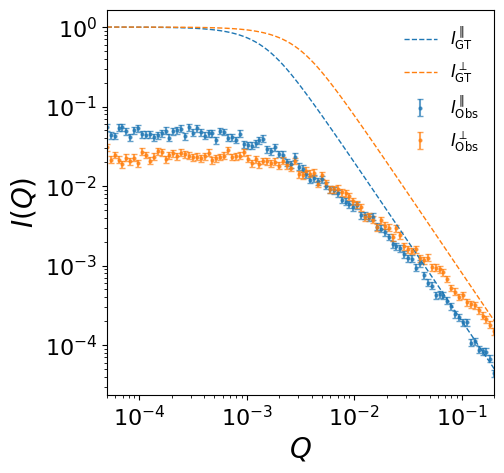

In [16]:
Q_min = 5e-5
Q_max = 0.2
# Q_sampled = np.linspace(Q_min, Q_max, 200)          # experimental Q
Q_sampled = np.logspace(np.log10(Q_min), np.log10(Q_max), 100)  # experimental Q

I_iso = S_gauss(Q_sampled,1000)
epsilon = 1
sigma_y = 0.1

## prepare the smeared observation in both orientations
def f_smear(R_raw, I_lat, Q_lat):
    w = np.zeros_like(Q_lat)
    w[1:-1] = 0.5 * (Q_lat[2:] - Q_lat[:-2])
    w[0]    = 0.5 * (Q_lat[1] - Q_lat[0])
    w[-1]   = 0.5 * (Q_lat[-1] - Q_lat[-2])
    num = R_raw * w[None, :]
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    R_mat = num / row_sum
    return R_mat @ I_lat, R_mat

# Choose orientation: phi = 0 (parallel) or phi = "pi/2" (perpendicular)
phi = 0  # or "pi/2"
R_raw = R_slit_aniso_rect(
    Q_obs=Q_sampled,
    q_mod=Q_sampled,      # latent grid = same as sampled grid here
    sigma_y=sigma_y,
    epsilon=epsilon,
    phi=phi,
    mu_q=0.0,
)                         # shape (N_obs, N_lat)
I_para, R_para = f_smear(R_raw, I_iso, Q_sampled)

phi = "pi/2" # perpendicular
R_raw = R_slit_aniso_rect(
    Q_obs=Q_sampled,
    q_mod=Q_sampled,      # latent grid = same as sampled grid here
    sigma_y=sigma_y,
    epsilon=epsilon,
    phi=phi,
    mu_q=0.0,
)                         # shape (N_obs, N_lat)
I_perp, R_perp = f_smear(R_raw, I_iso, Q_sampled)
Q_obs_para = Q_sampled
Q_obs_perp = Q_sampled

def poisson_observe_time(I_true, N=1000, *, I_scale=None, rng=None, eps=1e-12):
    """
    Poisson observation under FIXED TIME per Q:
    expected counts are proportional to intensity.

    Model:
      mu_i = N * I_true[i] / I_scale
      C_i ~ Poisson(mu_i)
      I_obs[i] = (C_i / N) * I_scale
      DeltaI[i] = (sqrt(C_i) / N) * I_scale

    Interpretation:
      - N sets the peak expected counts per Q
      - Equivalent to constant acquisition time

    If I_scale is None:
      I_scale = max(I_true)
    """
    I_true = np.asarray(I_true, float)
    if rng is None:
        rng = np.random.default_rng()
    if I_scale is None:
        I_scale = float(np.max(I_true))
    I_scale = max(I_scale, eps)

    mu = (N * I_true / I_scale).clip(min=0.0)
    C = rng.poisson(mu)

    I_obs = (C / N) * I_scale
    DeltaI = (np.sqrt(np.maximum(C, 1.0)) / N) * I_scale
    return I_obs, DeltaI, C, mu

def poisson_observe_count(I_true, N=1000, *, rng=None, eps=1e-12):
    """
    Poisson observation under FIXED COUNTS per Q:
    exactly N neutrons are collected at each Q.

    Model:
      T_i ~ Gamma(shape=N, scale=1/I_true[i])
      I_obs[i] = N / T_i
      DeltaI[i] = I_obs[i] / sqrt(N)

    Interpretation:
      - Each Q has identical counting statistics
      - Exposure time adapts to intensity

    This is the correct Poisson-limited estimator when counts are fixed.
    """
    I_true = np.asarray(I_true, float)
    if rng is None:
        rng = np.random.default_rng()

    I_safe = np.maximum(I_true, eps)

    # Gamma-distributed exposure time
    T = rng.gamma(shape=N, scale=1.0 / I_safe)

    I_obs = N / T
    DeltaI = I_obs / np.sqrt(N)
    
    C = N * np.ones_like(I_true)  # fixed counts

    return I_obs, DeltaI, C, T

# ---- use it for both orientations ----
N = 100
rng = np.random.default_rng(1234)

# you can choose a shared scale so both directions are on the same count scale
I_scale_shared = max(np.max(I_para), np.max(I_perp))

I_obs_para, Delta_I_obs_para, C_para, mu_para = poisson_observe_count(
    I_para, N=N, rng=rng
)
I_obs_perp, Delta_I_obs_perp, C_perp, mu_perp = poisson_observe_count(
    I_perp, N=N, rng=rng
)

I_gt_para = f_I_phi(
    Q=Q_sampled,
    I_iso=I_iso,
    epsilon=epsilon,
    phi="0",
    mu_q=0.0,
    kind="linear",
    )

I_gt_perp = f_I_phi(
    Q=Q_sampled,
    I_iso=I_iso,
    epsilon=epsilon,
    phi="pi/2",
    mu_q=0.0,
    kind="linear",
    )

## visualize the noisy observations
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(Q_obs_para, I_obs_para, yerr=Delta_I_obs_para,
            fmt='.', markersize=4, capsize=2, label=r'$I_\mathrm{Obs}^\parallel$', color='C0', alpha=0.7)
ax.errorbar(Q_obs_perp, I_obs_perp, yerr=Delta_I_obs_perp,
            fmt='.', markersize=4, capsize=2, label=r'$I_\mathrm{Obs}^\perp$', color='C1', alpha=0.7)
ax.plot(Q_sampled, I_gt_para, label=r'$I_\mathrm{GT}^\parallel$', color='C0', linestyle='--', linewidth=1)
ax.plot(Q_sampled, I_gt_perp, label=r'$I_\mathrm{GT}^\perp$', color='C1', linestyle='--', linewidth=1)
# ax.plot(Q_sampled, I_iso, label='True I_iso(q)', color='black', linestyle='--', linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$Q$", fontsize=20)
ax.set_ylabel(r"$I(Q)$", fontsize=20)
ax.set_xlim(Q_min, Q_max)
ax.legend(fontsize=12, frameon=False)   
ax.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [17]:
I_min_para = np.min(I_obs_para)
I_max_para = np.max(I_obs_para)
I_max_gt = np.max(I_iso)

I_prior = gaussian_filter1d(I_obs_para, sigma=15)

# Normalize the prior mean to match the range of I_min and I_max
I_prior_ratio = (np.log(I_prior) - np.log(I_prior.min())) / (np.log(I_prior.max()) - np.log(I_prior.min()))
I_prior = I_min_para * (I_max_gt / I_min_para)**I_prior_ratio

# --- Run GPR inversion (two orientations, one shared latent) ---
I_post, I_post_std, I_post_smeared_cat, \
I_prior, I_prior_smeared_cat, \
c_opt, Cov_f, K_lat, \
(I_post_smeared_para, I_post_smeared_perp), \
(I_prior_smeared_para, I_prior_smeared_perp), \
(R_para_gpr, R_perp_gpr, R_cat_gpr) = gpr_inversion_linear_operator_two_orientations(
    Q_obs_para, I_obs_para, Delta_I_obs_para,
    Q_obs_perp, I_obs_perp, Delta_I_obs_perp,
    Q_lat=Q_sampled,
    sigma_y_opt=sigma_y,
    epsilon=epsilon,
    psf_func=R_slit_aniso_rect,

    # kernel / prior options (typical starting point)
    lmbda_factor=10,
    smooth_sigma=2.0,
    prior_mean_user=I_prior,

    # amplitude: either fix c_user=... or let it optimize
    c_user=None,            # e.g. set c_user=0.3 to skip optimization
    log_c_min=-6.0,
    log_c_max=2.0,
    n_log_c=121,

    sigma_low=None,         # or e.g. sigma_low=0.2 if you want tighter prior at low Q
)

# I_post is the desmeared, isotropic latent spectrum on Q_sampled grid
# now evaluate directional spectra for comparison
I_map_para = f_I_phi(
    Q=Q_sampled,
    I_iso=I_post,
    epsilon=epsilon,
    phi="0",
    mu_q=0.0,
    kind="linear",
    )
I_map_perp = f_I_phi(
    Q=Q_sampled,
    I_iso=I_post,
    epsilon=epsilon,
    phi="pi/2",
    mu_q=0.0,
    kind="linear",
    )

_, Delta_I_map_para = f_I_phi_std(
    Q=Q_sampled,
    I_iso=I_post,
    delta_I_iso=I_post_std,
    epsilon=epsilon,
    phi="0",
    mu_q=0.0,
    kind="linear",
    )

_, Delta_I_map_perp = f_I_phi_std(
    Q=Q_sampled,
    I_iso=I_post,
    delta_I_iso=I_post_std,
    epsilon=epsilon,
    phi="pi/2",
    mu_q=0.0,
    kind="linear",
    )



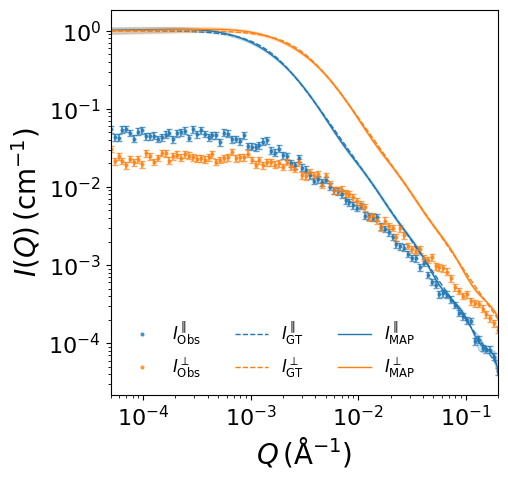

In [18]:
# =======================
#   Plot (ordered legend)
# =======================
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

handles = []
labels  = []

# --- Observations (para/perp) -------------------------------------------
h = ax.errorbar(Q_obs_para, I_obs_para, yerr=Delta_I_obs_para,
                fmt='.', markersize=4, capsize=2,
                color='C0', alpha=0.7)[0]
handles.append(h); labels.append(r'$I_\mathrm{Obs}^\parallel$')

h = ax.errorbar(Q_obs_perp, I_obs_perp, yerr=Delta_I_obs_perp,
                fmt='.', markersize=4, capsize=2,
                color='C1', alpha=0.7)[0]
handles.append(h); labels.append(r'$I_\mathrm{Obs}^\perp$')

# --- Ground truth (para/perp) -------------------------------------------
h, = ax.plot(Q_sampled, I_gt_para,
             color='C0', linestyle='--', linewidth=1)
handles.append(h); labels.append(r'$I_\mathrm{GT}^\parallel$')

h, = ax.plot(Q_sampled, I_gt_perp,
             color='C1', linestyle='--', linewidth=1)
handles.append(h); labels.append(r'$I_\mathrm{GT}^\perp$')

# --- MAP prediction (para/perp) -----------------------------------------
h, = ax.plot(Q_sampled, I_map_para,
             color='C0', linestyle='-', linewidth=1)
handles.append(h); labels.append(r'$I_\mathrm{MAP}^\parallel$')

h = ax.fill_between(Q_sampled,
                    I_map_para - Delta_I_map_para,
                    I_map_para + Delta_I_map_para,
                    color='C0', alpha=0.2)

h, = ax.plot(Q_sampled, I_map_perp,
             color='C1', linestyle='-', linewidth=1)
handles.append(h); labels.append(r'$I_\mathrm{MAP}^\perp$')

h = ax.fill_between(Q_sampled,
                    I_map_perp - Delta_I_map_perp,
                    I_map_perp + Delta_I_map_perp,
                    color='C1', alpha=0.2)

# Optional: isotropic MAP (single curve) if you prefer less duplication
# h, = ax.plot(Q_sampled, I_post, color='k', linestyle='-', linewidth=1.2)
# handles.append(h); labels.append(r'$I_\mathrm{MAP}$')

# # Optional: prior curve
# h, = ax.plot(Q_sampled, I_prior, color='gray', linestyle=':', linewidth=1)
# handles.append(h); labels.append(r'$I_\mathrm{prior}$')

# --- Axes formatting -----------------------------------------------------
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"$Q \, (\mathrm{\AA}^{-1})$", fontsize=20)
ax.set_ylabel(r"$I(Q) \, (\mathrm{cm}^{-1})$", fontsize=20)
ax.set_xlim(Q_min, Q_max)
ax.tick_params(axis='both', which='major', labelsize=16)

# Legend with controlled order
ax.legend(handles, labels, fontsize=12, frameon=False, ncol=3)

plt.show()


## get slit width and strain

In [13]:
import numpy as np

def _interp1d_flat(x, y, xq):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    xq = np.asarray(xq, float)
    return np.interp(xq, x, y, left=y[0], right=y[-1])

def _powerlaw_extrapolate(x, y, xq, *, k=8):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    xq = np.asarray(xq, float)

    eps = 1e-300
    y_pos = np.maximum(y, eps)
    k = int(min(k, len(x)))

    m_lo, b_lo = np.polyfit(np.log(x[:k]),  np.log(y_pos[:k]),  1)
    m_hi, b_hi = np.polyfit(np.log(x[-k:]), np.log(y_pos[-k:]), 1)

    y_mid = _interp1d_flat(x, y, np.clip(xq, x[0], x[-1]))
    yq = y_mid.copy()

    lo = xq < x[0]
    hi = xq > x[-1]
    if np.any(lo):
        yq[lo] = np.exp(b_lo) * np.power(xq[lo], m_lo)
    if np.any(hi):
        yq[hi] = np.exp(b_hi) * np.power(xq[hi], m_hi)
    return yq

def _apply_Rraw_smear(R_raw, I_lat, q_lat):
    """
    Exactly your forward operation:
      w from q_lat (trap rule),
      num = R_raw * w,
      row-normalize to get R_mat,
      return I_pred = R_mat @ I_lat.
    """
    q_lat = np.asarray(q_lat, float)
    I_lat = np.asarray(I_lat, float)
    R_raw = np.asarray(R_raw, float)

    w = np.zeros_like(q_lat)
    if len(q_lat) >= 2:
        w[1:-1] = 0.5 * (q_lat[2:] - q_lat[:-2])
        w[0]    = 0.5 * (q_lat[1] - q_lat[0])
        w[-1]   = 0.5 * (q_lat[-1] - q_lat[-2])
    else:
        w[:] = 1.0

    num = R_raw * w[None, :]
    row_sum = np.maximum(num.sum(axis=1, keepdims=True), 1e-300)
    R_mat = num / row_sum
    return R_mat @ I_lat, R_mat

import numpy as np
import matplotlib.pyplot as plt

def _qmin_needed_from_epsilon(Q_eval, epsilon):
    Q_eval = np.asarray(Q_eval, float)
    denom = max(1.0 + float(epsilon), 1e-6)
    return float(np.min(Q_eval) / denom)

def f_match(
    Q_obs_high, I_obs_high,                         # high-Q proxy for I_iso(q)
    Q_obs_low, I_obs_low_para, I_obs_low_perp,       # low-Q observations
    Delta_I_obs_low_para, Delta_I_obs_low_perp,      # low-Q uncertainties
    epsilon, sigma_y, *, mu_q=0.0,
    extrap_kind="powerlaw",                          # "powerlaw" or "flat"
    use_all_if_no_overlap=True,
    log_scale=False,
    I_floor=1e-300,
    qmin_from_epsilon=True,                          # fix ⟂ kernel needing lower-q support
    plot=False,                                      # NEW: plot or not
    show=True,                                       # NEW: show figures if plot=True
):
    """
    Weighted least-squares loss matching forward-smeared high-Q prediction to low-Q observations.
    Optionally plots the high-Q proxy, low-Q obs, and smeared predictions used in the loss.

    Notes:
      - Forward model uses R_slit_aniso_rect + _apply_Rraw_smear (must be defined elsewhere).
      - If log_scale=True, residuals use log-intensity; weights remain 1/Delta_I^2 (linear-space).
      - qmin_from_epsilon extends latent q-grid down to ~min(Q_eval)/(1+epsilon) to avoid truncation.
    """
    Qh = np.asarray(Q_obs_high, float)
    Ih = np.asarray(I_obs_high, float)

    Ql = np.asarray(Q_obs_low, float)
    Ilp = np.asarray(I_obs_low_para, float)
    Ilx = np.asarray(I_obs_low_perp, float)
    dIlp = np.asarray(Delta_I_obs_low_para, float)
    dIlx = np.asarray(Delta_I_obs_low_perp, float)

    # --- overlap region ---
    Q_high_min = float(np.min(Qh))
    Q_low_max  = float(np.max(Ql))
    mask_ol = (Ql > Q_high_min) & (Ql < Q_low_max)

    if np.any(mask_ol):
        mask_eval = mask_ol
    else:
        mask_eval = np.ones_like(Ql, dtype=bool) if use_all_if_no_overlap else mask_ol

    Q_eval  = Ql[mask_eval]
    Ilp_eval, Ilx_eval = Ilp[mask_eval], Ilx[mask_eval]
    dIlp_eval, dIlx_eval = dIlp[mask_eval], dIlx[mask_eval]

    # --- build I_iso on integration grid ---
    q_lat = Qh.copy()
    I_iso = Ih.copy()

    q_min_needed = float(np.min(Q_eval))
    if qmin_from_epsilon:
        q_min_needed = min(q_min_needed, _qmin_needed_from_epsilon(Q_eval, epsilon))
    q_max_needed = float(np.max(Q_eval))

    if (q_min_needed < q_lat[0]) or (q_max_needed > q_lat[-1]):
        n_ext = 80
        q_lo = (np.logspace(np.log10(q_min_needed), np.log10(q_lat[0]), n_ext, endpoint=False)
                if q_min_needed < q_lat[0] else np.array([], float))
        q_hi = (np.logspace(np.log10(q_lat[-1]), np.log10(q_max_needed), n_ext, endpoint=True)
                if q_max_needed > q_lat[-1] else np.array([], float))
        q_lat = np.unique(np.concatenate([q_lo, q_lat, q_hi]))

        if extrap_kind == "powerlaw":
            I_iso = _powerlaw_extrapolate(Qh, Ih, q_lat)
        elif extrap_kind == "flat":
            I_iso = _interp1d_flat(Qh, Ih, q_lat)
        else:
            raise ValueError("extrap_kind must be 'powerlaw' or 'flat'.")

    # --- forward smearing ---
    R_raw_para = R_slit_aniso_rect(
        Q_obs=Q_eval, q_mod=q_lat,
        sigma_y=sigma_y, epsilon=epsilon,
        phi=0, mu_q=mu_q,
    )
    I_pred_para, _ = _apply_Rraw_smear(R_raw_para, I_iso, q_lat)

    R_raw_perp = R_slit_aniso_rect(
        Q_obs=Q_eval, q_mod=q_lat,
        sigma_y=sigma_y, epsilon=epsilon,
        phi="pi/2", mu_q=mu_q,
    )
    I_pred_perp, _ = _apply_Rraw_smear(R_raw_perp, I_iso, q_lat)

    # --- optional log transform (for loss + plotting) ---
    if log_scale:
        I_pred_para_L = np.log(np.maximum(I_pred_para, I_floor))
        I_pred_perp_L = np.log(np.maximum(I_pred_perp, I_floor))
        Ilp_eval_L    = np.log(np.maximum(Ilp_eval,    I_floor))
        Ilx_eval_L    = np.log(np.maximum(Ilx_eval,    I_floor))
    else:
        I_pred_para_L, I_pred_perp_L = I_pred_para, I_pred_perp
        Ilp_eval_L, Ilx_eval_L = Ilp_eval, Ilx_eval

    # --- loss ---
    w_para = 1.0 / np.maximum(dIlp_eval, I_floor)**2
    w_perp = 1.0 / np.maximum(dIlx_eval, I_floor)**2

    r_para = I_pred_para_L - Ilp_eval_L
    r_perp = I_pred_perp_L - Ilx_eval_L
    loss = float(np.sum(w_para * r_para**2) + np.sum(w_perp * r_perp**2))

    # --- optional plotting ---
    if plot:
        if log_scale:
            ylab = r"$\log I$"
            Ih_plot  = np.log(np.maximum(Ih, I_floor))
            Ilp_plot = np.log(np.maximum(Ilp, I_floor))
            Ilx_plot = np.log(np.maximum(Ilx, I_floor))
            Ipred_p_plot = I_pred_para_L
            Ipred_x_plot = I_pred_perp_L
            plot_err = False  # log errorbars omitted
        else:
            ylab = r"$I$"
            Ih_plot, Ilp_plot, Ilx_plot = Ih, Ilp, Ilx
            Ipred_p_plot, Ipred_x_plot = I_pred_para, I_pred_perp
            plot_err = True

        # parallel
        plt.figure()
        plt.loglog(Qh, Ih_plot, marker=".", linestyle="None",
                   label="high-Q (proxy $I_{\\mathrm{iso}}$ input)")
        if plot_err:
            plt.errorbar(Ql, Ilp_plot, yerr=dIlp, fmt=".", linestyle="None",
                         label="low-Q obs (||)")
        else:
            plt.loglog(Ql, Ilp_plot, marker=".", linestyle="None",
                       label="low-Q obs (||)")
        plt.loglog(Q_eval, Ipred_p_plot, marker=".", linestyle="None",
                   label="smeared pred used in loss (||)")
        plt.xlabel(r"$Q$")
        plt.ylabel(ylab)
        plt.title("Overlap match: parallel (||)")
        plt.legend()
        plt.grid(True, which="both")

        # perpendicular
        plt.figure()
        plt.loglog(Qh, Ih_plot, marker=".", linestyle="None",
                   label="high-Q (proxy $I_{\\mathrm{iso}}$ input)")
        if plot_err:
            plt.errorbar(Ql, Ilx_plot, yerr=dIlx, fmt=".", linestyle="None",
                         label="low-Q obs ($\\perp$)")
        else:
            plt.loglog(Ql, Ilx_plot, marker=".", linestyle="None",
                       label="low-Q obs ($\\perp$)")
        plt.loglog(Q_eval, Ipred_x_plot, marker=".", linestyle="None",
                   label="smeared pred used in loss ($\\perp$)")
        plt.xlabel(r"$Q$")
        plt.ylabel(ylab)
        plt.title("Overlap match: perpendicular ($\\perp$)")
        plt.legend()
        plt.grid(True, which="both")

        if show:
            plt.show()

    return loss


In [14]:
import numpy as np
from scipy.optimize import minimize

def fit_eps_sigmay(
    Q_obs_high, I_obs_high,
    Q_obs_low, I_obs_low_para, I_obs_low_perp,
    Delta_I_obs_low_para, Delta_I_obs_low_perp,
    *,
    mu_q=0.0,
    log_scale=False,
    extrap_kind="powerlaw",
    qmin_from_epsilon=True,
    # optimization controls
    eps_bounds=(-0.9, 5.0),
    sig_bounds=(1e-6, 1.0),
    x0=(0.5, 0.05),
    method="L-BFGS-B",
    do_coarse_grid=True,
    grid_eps=(0.0, 2.0, 41),
    grid_sig=(0.005, 0.2, 41),
    verbose=True,
):
    """
    Optimize (epsilon, sigma_y) by minimizing the f_match loss over the overlap region.
    Requires your combined f_match(...) to be defined, and R_slit_aniso_rect(...) available.

    Returns:
      eps_opt, sig_opt, result (scipy OptimizeResult)
    """

    # --- optional coarse grid to get a robust initial guess ---
    if do_coarse_grid:
        e0, e1, ne = grid_eps
        s0, s1, ns = grid_sig
        eps_grid = np.linspace(e0, e1, int(ne))
        sig_grid = np.linspace(s0, s1, int(ns))

        best_L = np.inf
        best_x0 = x0
        for eps in eps_grid:
            for sig in sig_grid:
                L = f_match(
                    Q_obs_high, I_obs_high,
                    Q_obs_low, I_obs_low_para, I_obs_low_perp,
                    Delta_I_obs_low_para, Delta_I_obs_low_perp,
                    epsilon=eps, sigma_y=sig, mu_q=mu_q,
                    extrap_kind=extrap_kind,
                    log_scale=log_scale,
                    qmin_from_epsilon=qmin_from_epsilon,
                    plot=False,
                )
                if L < best_L:
                    best_L = L
                    best_x0 = (float(eps), float(sig))
        x0 = best_x0
        if verbose:
            print(f"[grid] best initial guess: epsilon={x0[0]:.6g}, sigma_y={x0[1]:.6g}, loss={best_L:.6g}")

    # --- objective wrapper ---
    def obj(x):
        eps, sig = float(x[0]), float(x[1])
        return f_match(
            Q_obs_high, I_obs_high,
            Q_obs_low, I_obs_low_para, I_obs_low_perp,
            Delta_I_obs_low_para, Delta_I_obs_low_perp,
            epsilon=eps, sigma_y=sig, mu_q=mu_q,
            extrap_kind=extrap_kind,
            log_scale=log_scale,
            qmin_from_epsilon=qmin_from_epsilon,
            plot=False,
        )

    bounds = [eps_bounds, sig_bounds]
    res = minimize(obj, x0=np.array(x0, float), method=method, bounds=bounds)

    eps_opt, sig_opt = float(res.x[0]), float(res.x[1])
    if verbose:
        print(f"[opt] success={res.success}  message={res.message}")
        print(f"[opt] epsilon_opt={eps_opt:.6g}, sigma_y_opt={sig_opt:.6g}, loss={res.fun:.6g}")

    return eps_opt, sig_opt, res


[grid] best initial guess: epsilon=1.05, sigma_y=0.1, loss=0.730676
[opt] success=True  message=CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
[opt] epsilon_opt=1.03992, sigma_y_opt=0.0999, loss=0.703443


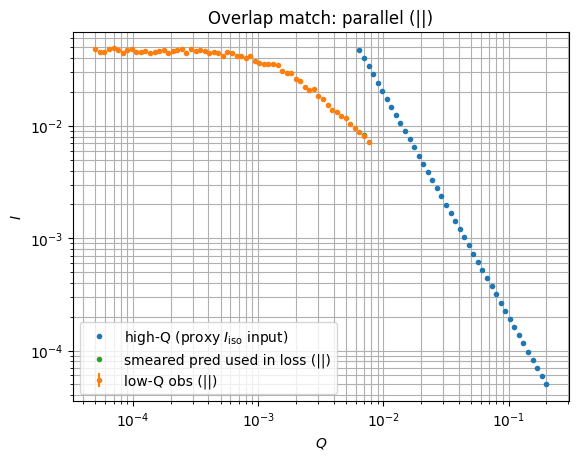

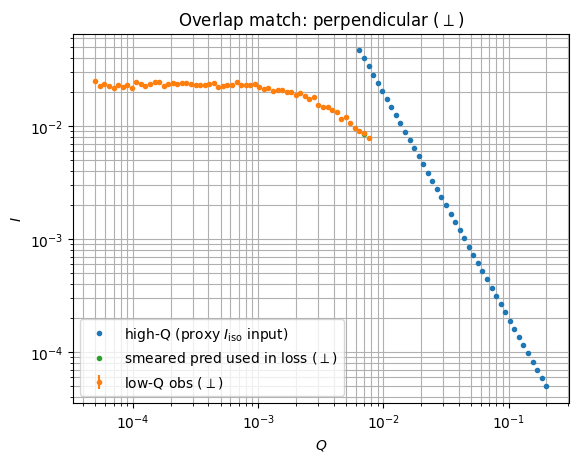

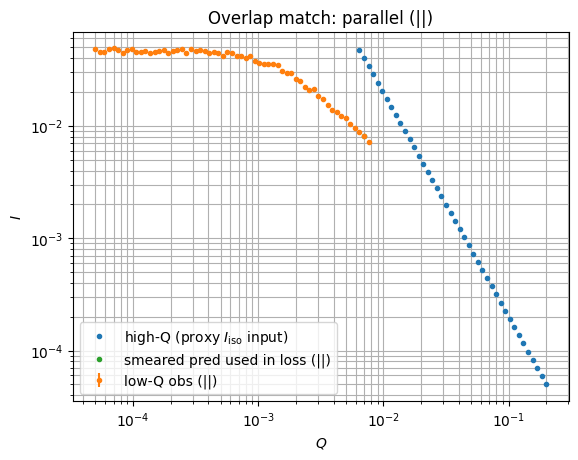

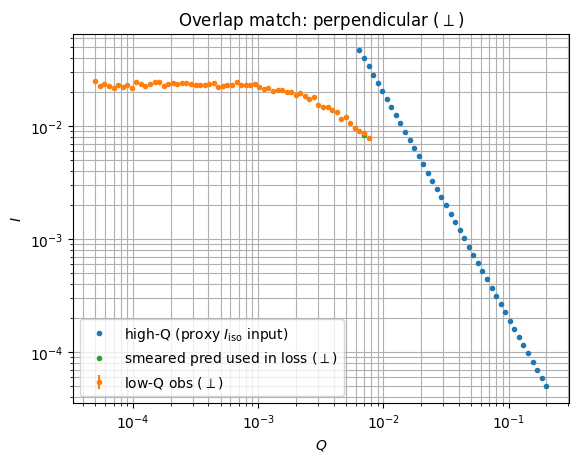

Loss at optimum: 0.703443, Loss at ground truth: 1.44275


In [15]:
Q_high_min = 0.006
Q_low_max = 0.008

Q_high_mask = Q_sampled >= Q_high_min
Q_obs_high = Q_sampled[Q_high_mask]
I_obs_high = I_iso[Q_high_mask]

Q_low_mask = Q_sampled <= Q_low_max
Q_obs_low = Q_sampled[Q_low_mask]
I_obs_low_para = I_obs_para[Q_low_mask]
I_obs_low_perp = I_obs_perp[Q_low_mask]
Delta_I_obs_low_para = Delta_I_obs_para[Q_low_mask]
Delta_I_obs_low_perp = Delta_I_obs_perp[Q_low_mask]

# ---------------------------
# Example: run the fit
# ---------------------------
eps_opt, sigma_y_opt, res = fit_eps_sigmay(
    Q_obs_high, I_obs_high,
    Q_obs_low, I_obs_low_para, I_obs_low_perp,
    Delta_I_obs_low_para, Delta_I_obs_low_perp,
    mu_q=0.0,
    log_scale=False,          # or True
    eps_bounds=(0, 2.0),
    sig_bounds=(0.0999, 0.1001),
    x0=(0.5, 0.05),
    do_coarse_grid=True,      # robust start
    grid_eps=(0.0, 2.0, 41),
    grid_sig=(0.1, 0.1, 1),
    verbose=True,
)

# Plot the match at the optimum (uses your combined f_match(plot=True))
loss_opt = f_match(
    Q_obs_high, I_obs_high,
    Q_obs_low, I_obs_low_para, I_obs_low_perp,
    Delta_I_obs_low_para, Delta_I_obs_low_perp,
    epsilon=eps_opt, sigma_y=sigma_y_opt,
    mu_q=0.0,
    log_scale=False,          # keep consistent with fitting choice
    plot=True, show=True,
)

loss_gt = f_match(
    Q_obs_high, I_obs_high,
    Q_obs_low, I_obs_low_para, I_obs_low_perp,
    Delta_I_obs_low_para, Delta_I_obs_low_perp,
    epsilon=epsilon, sigma_y=sigma_y,
    mu_q=0.0,
    log_scale=False,          # keep consistent with fitting choice
    plot=True, show=True,
)

print(f"Loss at optimum: {loss_opt:.6g}, Loss at ground truth: {loss_gt:.6g}")